In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

In [2]:
seed = 0
num_hidden_layers = 2
input_dim = 20
hidden_dim = 10
output_dim = input_dim
sigma = 0.75  # 2
wrap = True
input_peak_rate = 1.
num_blocks = 10  # each block contains all input patterns

hidden_layer_target_density = 0.2
inhib_gate_shape = 4.

activation_f = lambda x: x

learning_rate = 0.25
dep_ratio = 1.
dep_th = 0.01
dep_width = 0.01
update_FB_weights = False
set_output_activities = False

this_random = np.random.RandomState()
this_random.seed(seed)

In [3]:
input_pattern_matrix = np.empty([input_dim,input_dim])
target_output_matrix = np.zeros([input_dim,input_dim])

input_indexes = np.arange(0, input_dim)
center_index = (input_dim-1)//2
field = input_peak_rate * np.exp(-((input_indexes-center_index)/sigma)**2.)

for i in input_indexes:
    if wrap:
        input_pattern_matrix[i,:] = np.roll(field, i-center_index)
    else:
        input_pattern_matrix[i,:] = input_peak_rate * np.exp(-((input_indexes-i)/sigma)**2.)

target_output_matrix = np.copy(input_pattern_matrix)

num_input_patterns = input_pattern_matrix.shape[-1]
input_layer_density = np.mean(np.mean(input_pattern_matrix, axis=0))
output_layer_density = np.mean(np.mean(target_output_matrix, axis=0))

<IPython.core.display.Javascript object>


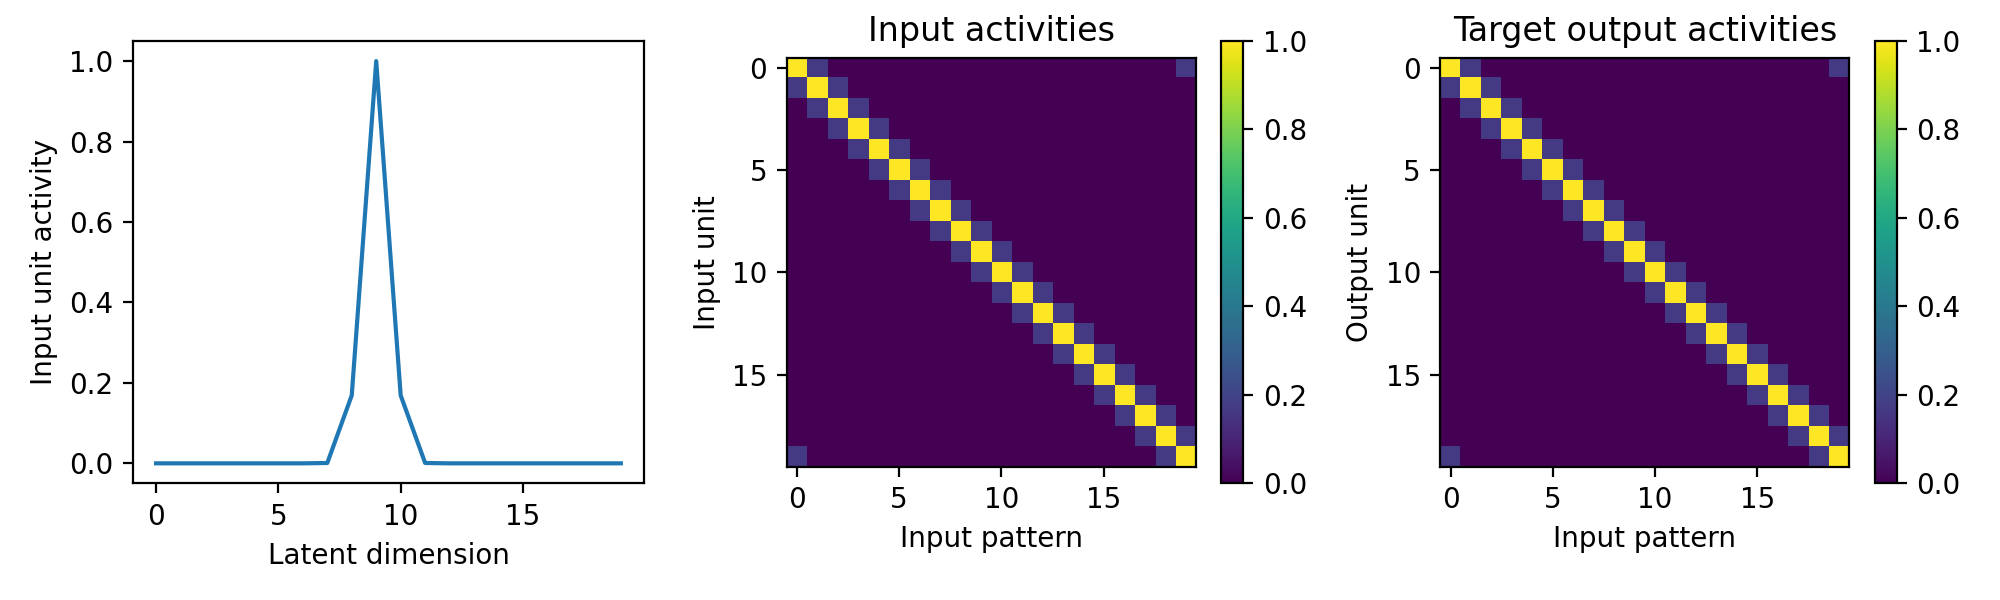

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
axes[0].plot(input_indexes, field)
axes[0].set_ylabel('Input unit activity')
axes[0].set_xlabel('Latent dimension')

cbar = axes[1].imshow(input_pattern_matrix)
fig.colorbar(cbar, ax=axes[1])
axes[1].set_xlabel('Input pattern')
axes[1].set_ylabel('Input unit')
axes[1].set_title('Input activities')

cbar = axes[2].imshow(target_output_matrix)
fig.colorbar(cbar, ax=axes[2])
axes[2].set_xlabel('Input pattern')
axes[2].set_ylabel('Output unit')
axes[2].set_title('Target output activities')

fig.tight_layout()

In [4]:
max_weight_scale = 2.
initial_weight_scale = max_weight_scale / 2.

initial_FF_weight_scale_dict = {}
initial_FB_weight_scale_dict = {}
max_FF_weight_dict = {}
max_FB_weight_dict = {}
num_layers = num_hidden_layers + 2
layer_dims = [input_dim] + num_hidden_layers * [hidden_dim] + [output_dim]
layer_densities = [input_layer_density] + num_hidden_layers * [hidden_layer_target_density] + [output_layer_density]

initial_FF_weight_matrix_dict = {}
initial_FB_weight_matrix_dict = {}

for layer in range(1, num_layers):
    prev_layer_dim = layer_dims[layer-1]
    curr_layer_dim = layer_dims[layer]
    prev_layer_density = layer_densities[layer-1]
    curr_layer_density = layer_densities[layer]
    this_initial_weight_scale = initial_weight_scale / prev_layer_dim / prev_layer_density * curr_layer_density
    initial_FF_weight_scale_dict[layer] = this_initial_weight_scale
    this_max_weight = max_weight_scale / prev_layer_dim / prev_layer_density
    if layer == num_layers - 1:
        this_max_weight *= 2.
    max_FF_weight_dict[layer] = this_max_weight
    initial_FF_weight_matrix_dict[layer] = this_random.uniform(0., this_initial_weight_scale, [curr_layer_dim, prev_layer_dim])
    
for layer in range(1, num_layers - 1):
    next_layer_dim = layer_dims[layer+1]
    curr_layer_dim = layer_dims[layer]
    next_layer_density = layer_densities[layer+1]
    curr_layer_density = layer_densities[layer]
    this_initial_weight_scale = initial_weight_scale / next_layer_dim / next_layer_density * curr_layer_density
    initial_FB_weight_scale_dict[layer] = this_initial_weight_scale
    this_max_weight = max_weight_scale / next_layer_dim / next_layer_density
    max_FB_weight_dict[layer] = this_max_weight * 2.
    initial_FB_weight_matrix_dict[layer] = this_random.uniform(0., this_initial_weight_scale, [curr_layer_dim, next_layer_dim])

In [5]:
print(layer_densities)
print(max_FF_weight_dict)
print(max_FB_weight_dict)

[0.06698294157767565, 0.2, 0.2, 0.06698294157767565]
{1: 1.4929174151606448, 2: 1.0, 3: 2.0}
{1: 2.0, 2: 2.9858348303212896}


In [6]:
def get_layer_activities(input_pattern_matrix, FF_weight_matrix_dict, FB_weight_matrix_dict, activation_f, target_output_matrix=None, set_output_activities=False):
    FF_input_activities_dict = {}
    FB_input_activities_dict = {}
    layer_output_activities_dict = {}
    layer_output_activities_dict[0] = np.copy(input_pattern_matrix)
    prev_layer_activities = input_pattern_matrix
    sorted_layers = sorted(list(FF_weight_matrix_dict.keys()))
    output_layer = max(sorted_layers)
    for layer in sorted_layers:
        curr_layer_input_activities = FF_weight_matrix_dict[layer].dot(prev_layer_activities)
        FF_input_activities_dict[layer] = np.copy(curr_layer_input_activities)
        if layer == output_layer and set_output_activities:
            if target_output_matrix is None:
                raise RuntimeError('get_layer_activities: cannot set_output_activities without target_output_matrix')
            curr_layer_output_activities = target_output_matrix
        else:
            curr_layer_output_activities = activation_f(curr_layer_input_activities)
        layer_output_activities_dict[layer] = np.copy(curr_layer_output_activities)
        prev_layer_activities = curr_layer_output_activities
    for layer in sorted(list(FB_weight_matrix_dict), reverse=True):
        curr_layer_input_activities = FB_weight_matrix_dict[layer].dot(prev_layer_activities)
        FB_input_activities_dict[layer] = np.copy(curr_layer_input_activities)
        prev_layer_activities = layer_output_activities_dict[layer]
    return FF_input_activities_dict, FB_input_activities_dict, layer_output_activities_dict


def plot_network_state_summary(FF_weight_matrix_dict, FB_weight_matrix_dict, FF_input_activities_dict, FB_input_activities_dict, layer_output_activities_dict):    

    fig, axes = plt.subplots(5, len(FF_weight_matrix_dict) + 1, figsize=(int(len(FF_weight_matrix_dict) + 1) * 3.5, 2.5 * 5))
    for layer in sorted(list(layer_output_activities_dict.keys())):
        if layer in FF_weight_matrix_dict:
            cbar = axes[0][layer].imshow(FF_weight_matrix_dict[layer])
            fig.colorbar(cbar, ax=axes[0][layer])
            axes[0][layer].set_title('FF weights: layer %i' % layer)
            axes[0][layer].set_ylabel('Layer %i units' % layer)
            axes[0][layer].set_xlabel('Layer %i units' % (layer - 1))

            cbar = axes[1][layer].imshow(FF_input_activities_dict[layer])
            fig.colorbar(cbar, ax=axes[1][layer])
            axes[1][layer].set_title('FF input activities: layer %i' % layer)
            axes[1][layer].set_ylabel('Layer %i units' % layer)
            axes[1][layer].set_xlabel('Input patterns')
        
        cbar = axes[2][layer].imshow(layer_output_activities_dict[layer])
        fig.colorbar(cbar, ax=axes[2][layer])
        if layer == 0:
            axes[2][layer].set_title('Input layer activities')
        else:
            axes[2][layer].set_title('Output activities: layer %i' % layer)
        axes[2][layer].set_ylabel('Layer %i units' % layer)
        axes[2][layer].set_xlabel('Input patterns')
        
        if layer in FB_weight_matrix_dict:
            cbar = axes[3][layer].imshow(FB_weight_matrix_dict[layer])
            fig.colorbar(cbar, ax=axes[3][layer])
            axes[3][layer].set_title('FB weights: layer %i' % layer)
            axes[3][layer].set_ylabel('Layer %i units' % layer)
            axes[3][layer].set_xlabel('Layer %i units' % (layer + 1))

            cbar = axes[4][layer].imshow(FB_input_activities_dict[layer])
            fig.colorbar(cbar, ax=axes[4][layer])
            axes[4][layer].set_title('FB input activities: layer %i' % layer)
            axes[4][layer].set_ylabel('Layer %i units' % layer)
            axes[4][layer].set_xlabel('Input patterns')
        axes[3][-1].axis('off')
        axes[4][-1].axis('off')
    for i in range(len(axes)):
        if i != 2:
            axes[i, 0].axis('off')
    fig.subplots_adjust(wspace=0.1, hspace=0.8)
    fig.show()
    print('Activity densities:')
    for layer in layer_output_activities_dict:
        print('layer %i: %.2f' % (layer, np.mean(np.mean(layer_output_activities_dict[layer], axis=0))))
        


def scaled_single_sigmoid(th, peak, x=None, ylim=None):
    """
    Transform a sigmoid to intersect x and y range limits.
    :param th: float
    :param peak: float
    :param x: array
    :param ylim: pair of float
    :return: callable
    """
    if x is None:
        x = (0., 1.)
    if ylim is None:
        ylim = (0., 1.)
    if th < x[0] or th > x[-1]:
        raise ValueError('scaled_single_sigmoid: th: %.2E is out of range for xlim: [%.2E, %.2E]' % (th, x[0], x[-1]))
    if peak == th:
        raise ValueError('scaled_single_sigmoid: peak and th: %.2E cannot be equal' % th)
    slope = 2. / (peak - th)
    y = lambda x: 1. / (1. + np.exp(-slope * (x - th)))
    start_val = y(x[0])
    end_val = y(x[-1])
    amp = end_val - start_val
    target_amp = ylim[1] - ylim[0]
    return lambda xi: (target_amp / amp) * (1. / (1. + np.exp(-slope * (xi - th))) - start_val) + ylim[0]


def get_BTSP_delta_w(learning_rate, dep_ratio, dep_th, dep_width):
    f_dep = scaled_single_sigmoid(dep_th, dep_th + dep_width)
    return np.vectorize(lambda pre, w, mod, w_max: learning_rate * ((w_max - w) * pre * mod - w * dep_ratio * f_dep(pre * mod)), excluded=['mod', 'w_max'])

<IPython.core.display.Javascript object>


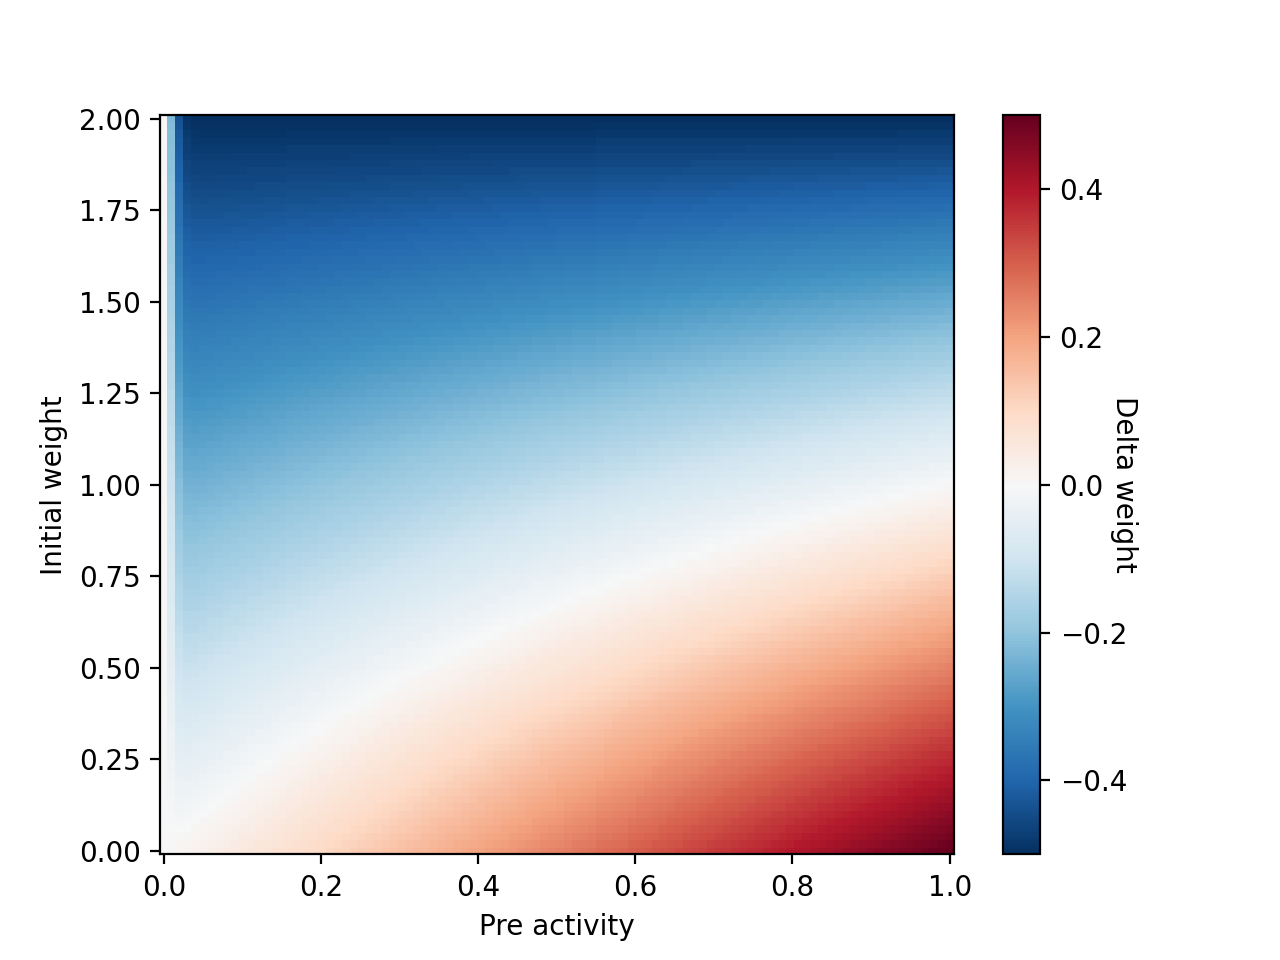

In [7]:
BTSP_delta_w = get_BTSP_delta_w(learning_rate, dep_ratio, dep_th, dep_width)
pre = np.linspace(0., input_peak_rate, 100)
w0 = np.linspace(0., max_weight_scale, 100)
pre_mesh, w0_mesh = np.meshgrid(pre, w0)
plt.figure()
plt.pcolormesh(pre_mesh, w0_mesh, BTSP_delta_w(pre_mesh, w0_mesh, 1., max_weight_scale), cmap='RdBu_r', shading='nearest', vmin=-max_weight_scale * learning_rate, 
               vmax=max_weight_scale * learning_rate)
plt.xlabel('Pre activity')
plt.ylabel('Initial weight')
cbar = plt.colorbar()
cbar.set_label('Delta weight', rotation=-90.)

<IPython.core.display.Javascript object>


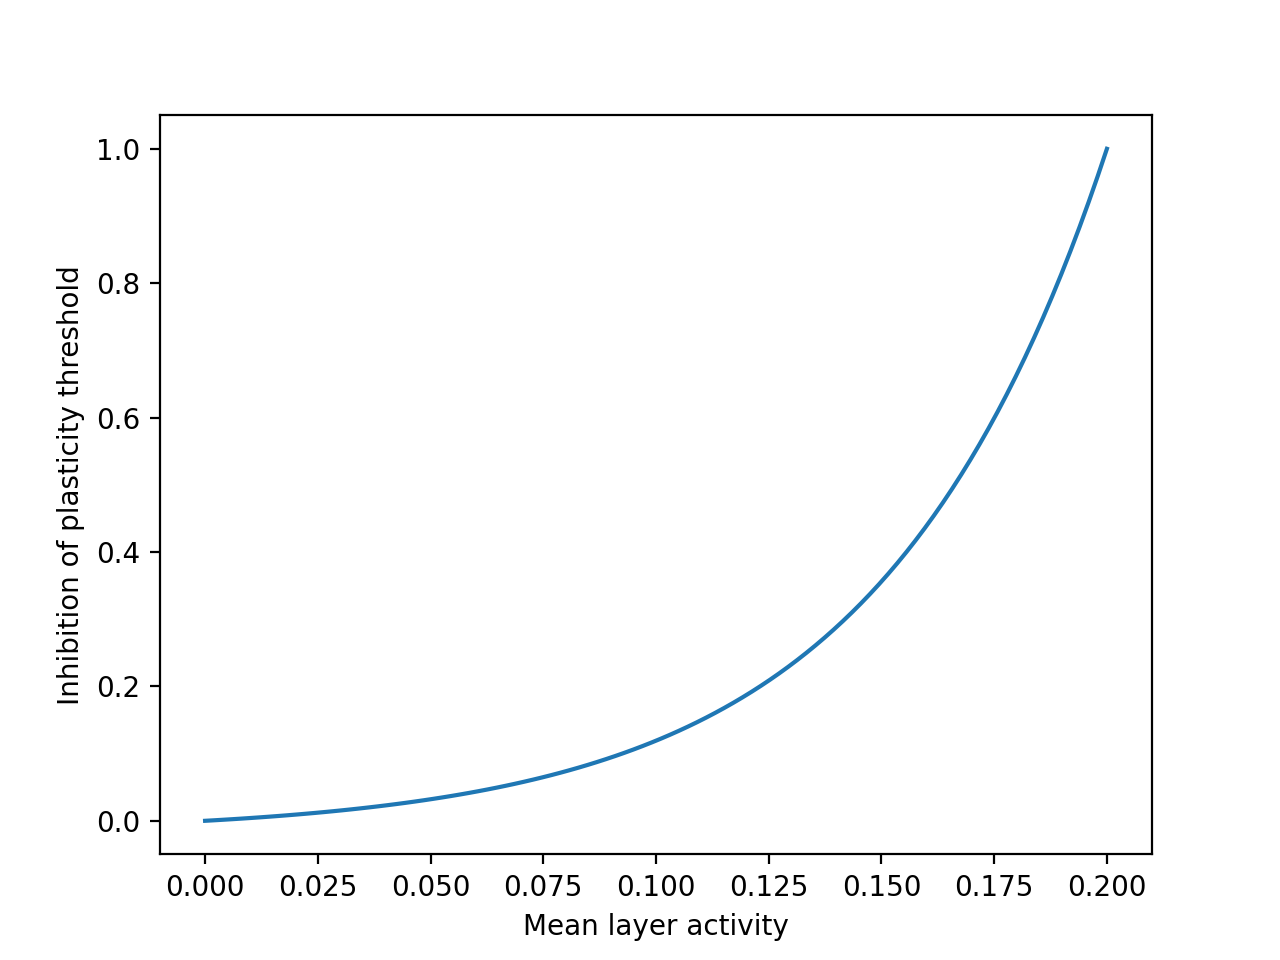

In [8]:
def inhib_gate(x, target_density, shape):
    y = lambda x: np.exp(shape * ((x / target_density) - 1.))
    return (y(x) - y(0.)) / (1. - y(0.))
target_density = 0.2
plt.figure()
test = np.linspace(0., target_density, 100)
plt.plot(test, inhib_gate(test, target_density, inhib_gate_shape))
plt.xlabel('Mean layer activity')
plt.ylabel('Inhibition of plasticity threshold')
plt.show()

In [9]:
def get_layer_mod_activities(FF_input_activities_dict, FB_input_activities_dict, layer_output_activities_dict, target_mod, layer_densities):
    # print('Hidden layer update not yet implemented')
    layer_mod_activities_dict = {}
    num_layers = len(layer_densities)
    for layer in range(1, num_layers):
        if layer == num_layers - 1:
            layer_mod_activities_dict[layer] = np.copy(target_mod)
        else:
            inhib = inhib_gate(np.mean(layer_output_activities_dict[layer]), layer_densities[layer], inhib_gate_shape)
            FF_gate = np.heaviside(FF_input_activities_dict[layer] - inhib, 1.)
            FB_gate = np.heaviside(FB_input_activities_dict[layer] - inhib, 1.)
            layer_mod_activities_dict[layer] = np.multiply(FF_gate, FB_gate)
    return layer_mod_activities_dict


def get_BTSP_delta_weights(layer_output_activities_dict, layer_mod_activities_dict, FF_weight_matrix_dict, FB_weight_matrix_dict, max_FF_weight_dict, max_FB_weight_dict, 
                           update_FB_weights=False):
    delta_FF_weight_matrix_dict = {}
    delta_FB_weight_matrix_dict = {}
    for layer in FF_weight_matrix_dict:
        pre = layer_output_activities_dict[layer - 1]
        mod = layer_mod_activities_dict[layer]
        max_weight = max_FF_weight_dict[layer]
        delta_FF_weight_matrix = np.empty_like(FF_weight_matrix_dict[layer])
        for i in range(len(mod)):
            delta_FF_weight_matrix[i] = BTSP_delta_w(pre, FF_weight_matrix_dict[layer][i], mod[i], max_weight)
        delta_FF_weight_matrix_dict[layer] = np.copy(delta_FF_weight_matrix)
    for layer in FB_weight_matrix_dict:
        if update_FB_weights:
            pre = layer_output_activities_dict[layer + 1]
            mod = layer_mod_activities_dict[layer]
            max_weight = max_FB_weight_dict[layer]
            delta_FB_weight_matrix = np.empty_like(FB_weight_matrix_dict[layer])
            for i in range(len(mod)):
                delta_FB_weight_matrix[i] = BTSP_delta_w(pre, FB_weight_matrix_dict[layer][i], mod[i], max_weight)
            delta_FB_weight_matrix_dict[layer] = np.copy(delta_FB_weight_matrix)
        else:
            delta_FB_weight_matrix_dict[layer] = np.zeros_like(FB_weight_matrix_dict[layer])
    return delta_FF_weight_matrix_dict, delta_FB_weight_matrix_dict
    

def train_BTSP(input_pattern_matrix, target_output_matrix, initial_FF_weight_matrix_dict, initial_FB_weight_matrix_dict, num_blocks, layer_densities, activation_f, 
               max_FF_weight_dict, max_FB_weight_dict, update_FB_weights=False, set_output_activities=False):
    
    FF_weight_matrix_dict = deepcopy(initial_FF_weight_matrix_dict)
    FB_weight_matrix_dict = deepcopy(initial_FB_weight_matrix_dict)
    FF_weight_matrix_dict_history = []
    FB_weight_matrix_dict_history = []
    delta_FF_weight_matrix_dict_history = []
    delta_FB_weight_matrix_dict_history = []
    input_pattern_index_history = []
    layer_output_activities_dict_history = []
    layer_mod_activities_dict_history = []
    
    num_layers = len(layer_densities)
    for block in range(num_blocks):
        input_pattern_indexes = np.arange(input_pattern_matrix.shape[-1])
        this_random.shuffle(input_pattern_indexes)
        for input_pattern_index in input_pattern_indexes:
            input_pattern_index_history.append(input_pattern_index)
            input_pattern = input_pattern_matrix[:, input_pattern_index]
            target_output = target_output_matrix[:, input_pattern_index]
            target_mod = np.zeros_like(target_output)
            target_mod[np.argmax(target_output)] = 1.
            FF_input_activities_dict, FB_input_activities_dict, layer_output_activities_dict = \
                get_layer_activities(input_pattern, FF_weight_matrix_dict, FB_weight_matrix_dict, activation_f, target_output, set_output_activities)
            layer_mod_activities_dict = get_layer_mod_activities(FF_input_activities_dict, FB_input_activities_dict, layer_output_activities_dict, target_mod, layer_densities)
            delta_FF_weight_matrix_dict, delta_FB_weight_matrix_dict = \
                get_BTSP_delta_weights(layer_output_activities_dict, layer_mod_activities_dict, FF_weight_matrix_dict, FB_weight_matrix_dict, max_FF_weight_dict, max_FB_weight_dict, 
                                       update_FB_weights)
            delta_FF_weight_matrix_dict_history.append(deepcopy(delta_FF_weight_matrix_dict))
            delta_FB_weight_matrix_dict_history.append(deepcopy(delta_FB_weight_matrix_dict))
            layer_output_activities_dict_history.append(deepcopy(layer_output_activities_dict))
            layer_mod_activities_dict_history.append(deepcopy(layer_mod_activities_dict))
            for layer in FF_weight_matrix_dict:
                FF_weight_matrix_dict[layer] += delta_FF_weight_matrix_dict[layer]
            if update_FB_weights:
                for layer in FB_weight_matrix_dict:
                    FB_weight_matrix_dict[layer] += delta_FB_weight_matrix_dict[layer]
            FF_weight_matrix_dict_history.append(deepcopy(FF_weight_matrix_dict))
            FB_weight_matrix_dict_history.append(deepcopy(FB_weight_matrix_dict))
    return FF_weight_matrix_dict_history, FB_weight_matrix_dict_history, delta_FF_weight_matrix_dict_history, delta_FB_weight_matrix_dict_history, input_pattern_index_history, \
        layer_output_activities_dict_history, layer_mod_activities_dict_history

In [10]:
FF_weight_matrix_dict_history, FB_weight_matrix_dict_history, delta_FF_weight_matrix_dict_history, delta_FB_weight_matrix_dict_history, input_pattern_index_history, \
    layer_output_activities_dict_history, layer_mod_activities_dict_history = \
    train_BTSP(input_pattern_matrix, target_output_matrix, initial_FF_weight_matrix_dict, initial_FB_weight_matrix_dict, num_blocks, layer_densities, activation_f, max_FF_weight_dict, 
               max_FB_weight_dict, update_FB_weights=update_FB_weights, set_output_activities=set_output_activities)

<IPython.core.display.Javascript object>


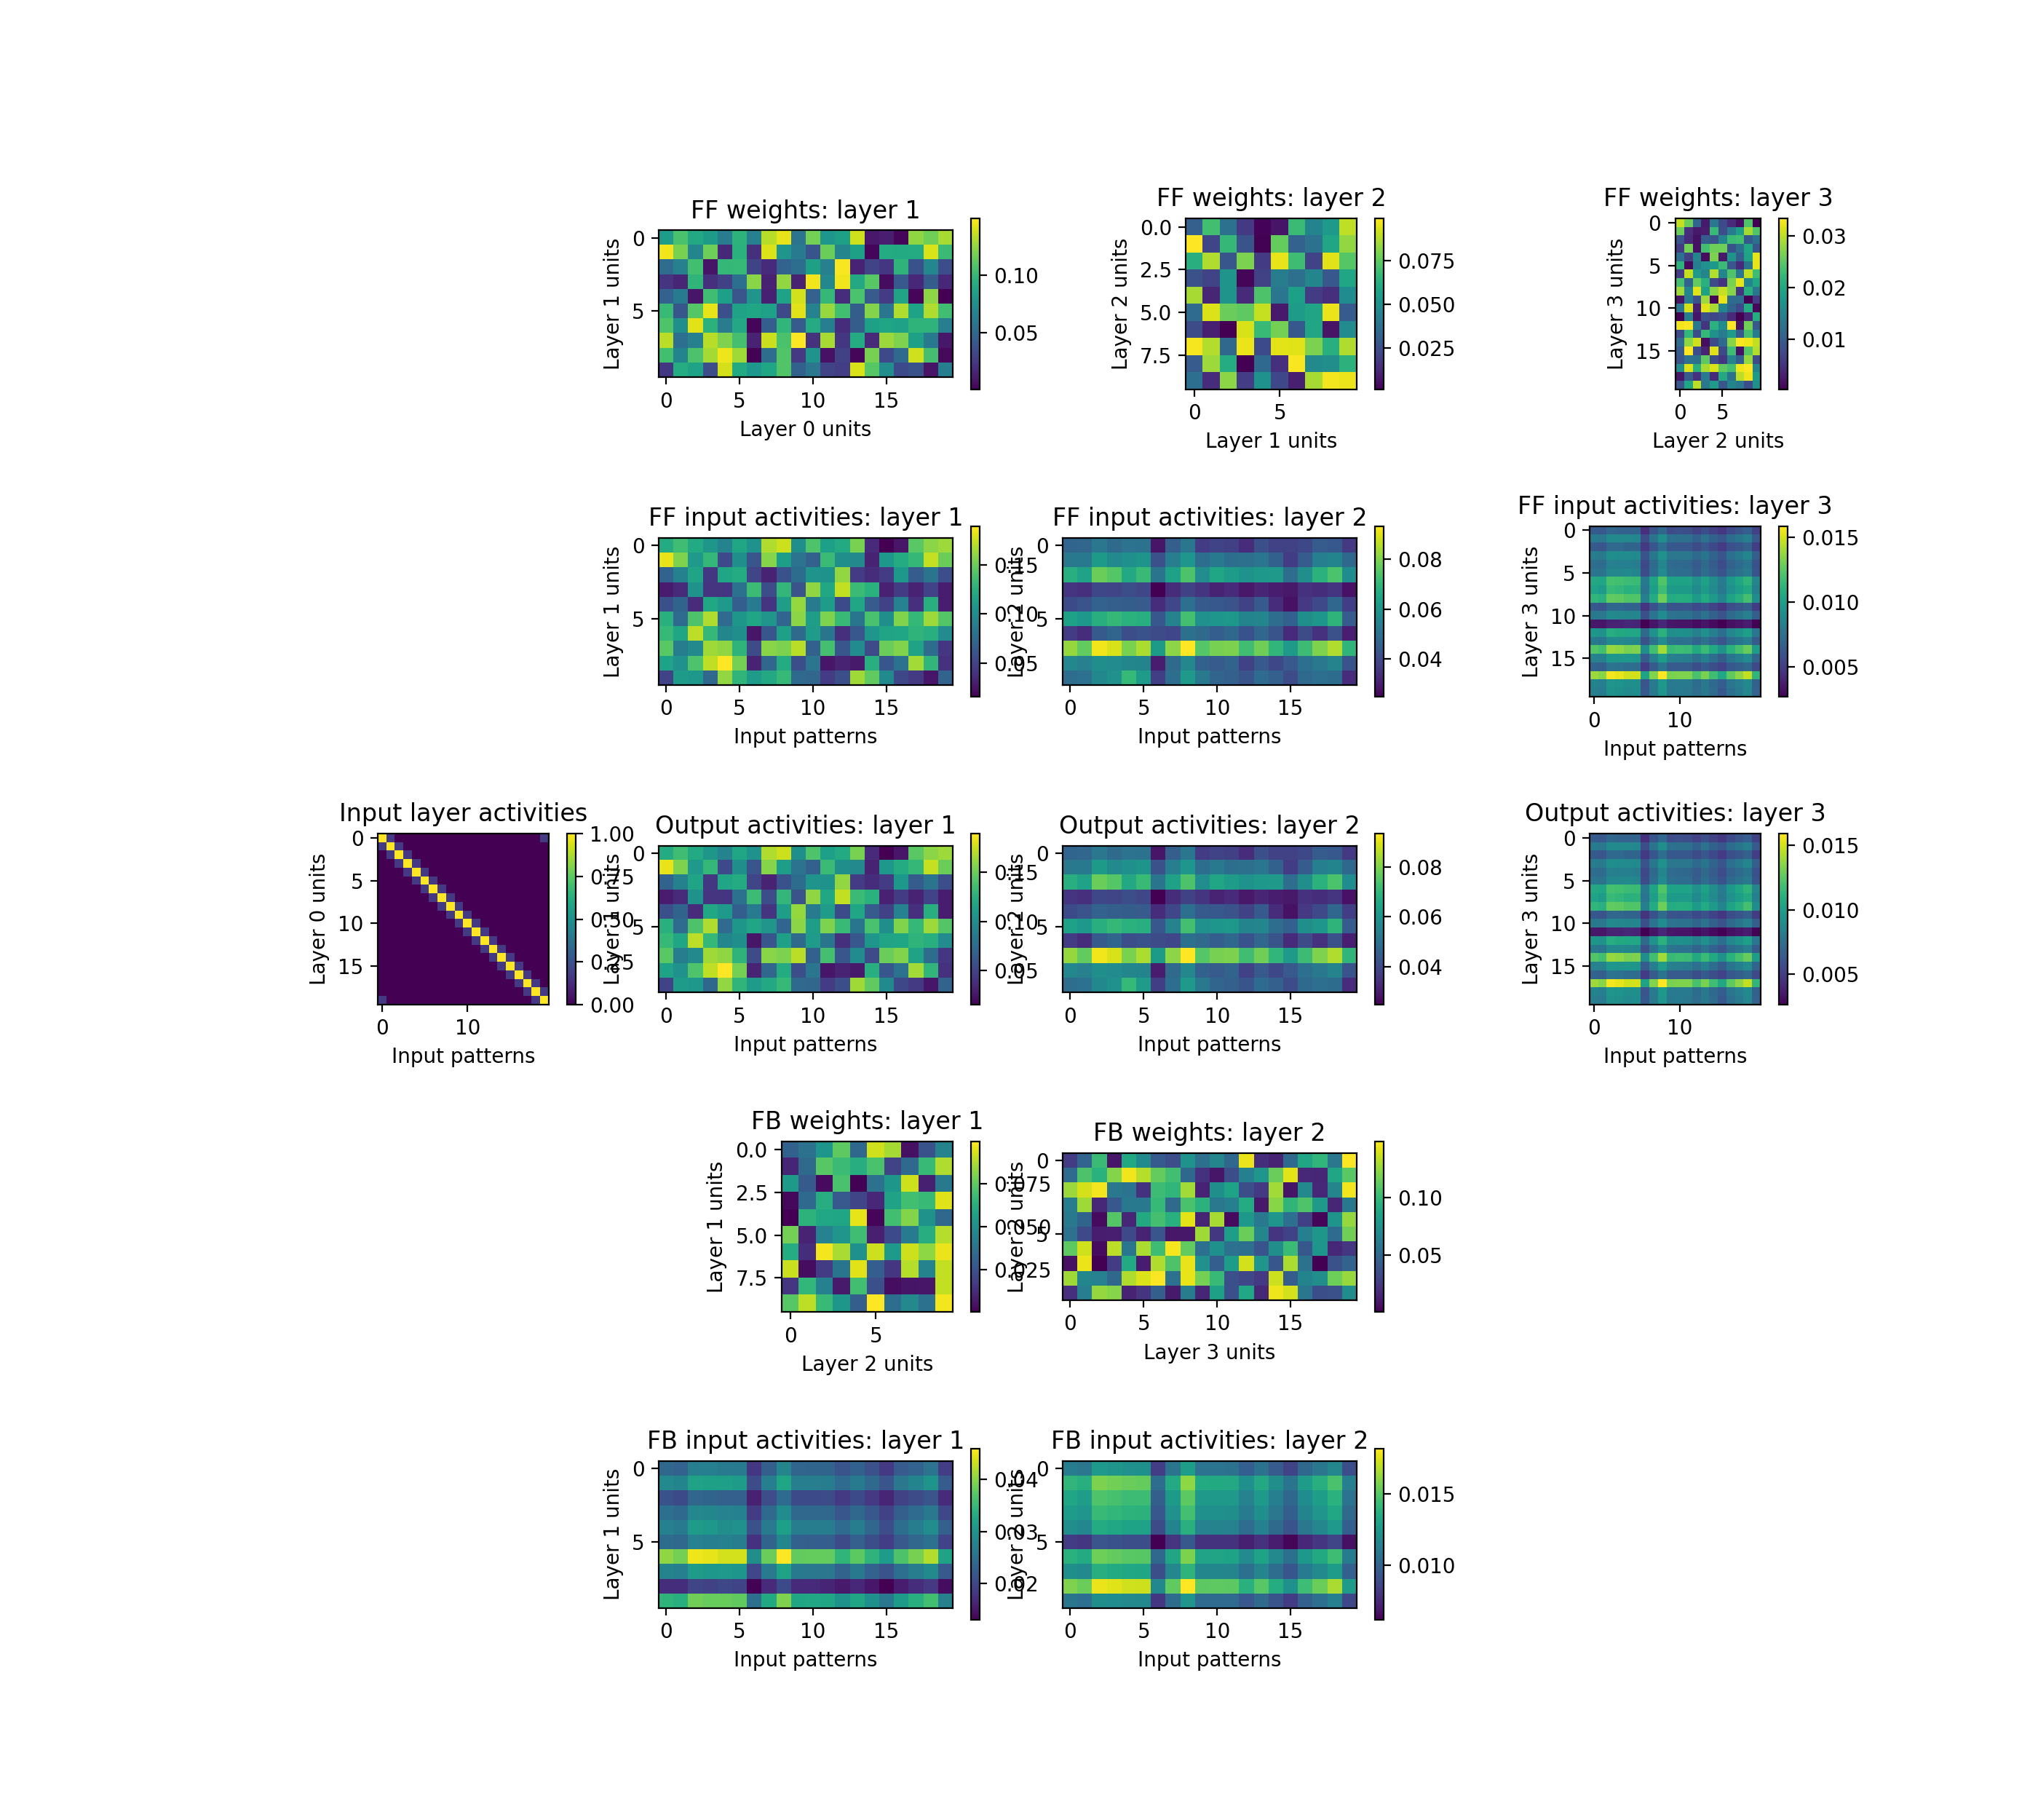

Activity densities:
layer 0: 0.07
layer 1: 0.10
layer 2: 0.05
layer 3: 0.01


In [11]:
FF_input_activities_dict, FB_input_activities_dict, layer_output_activities_dict = \
    get_layer_activities(input_pattern_matrix, initial_FF_weight_matrix_dict, initial_FB_weight_matrix_dict, activation_f)
plot_network_state_summary(initial_FF_weight_matrix_dict, initial_FB_weight_matrix_dict, FF_input_activities_dict, FB_input_activities_dict, layer_output_activities_dict)

<IPython.core.display.Javascript object>


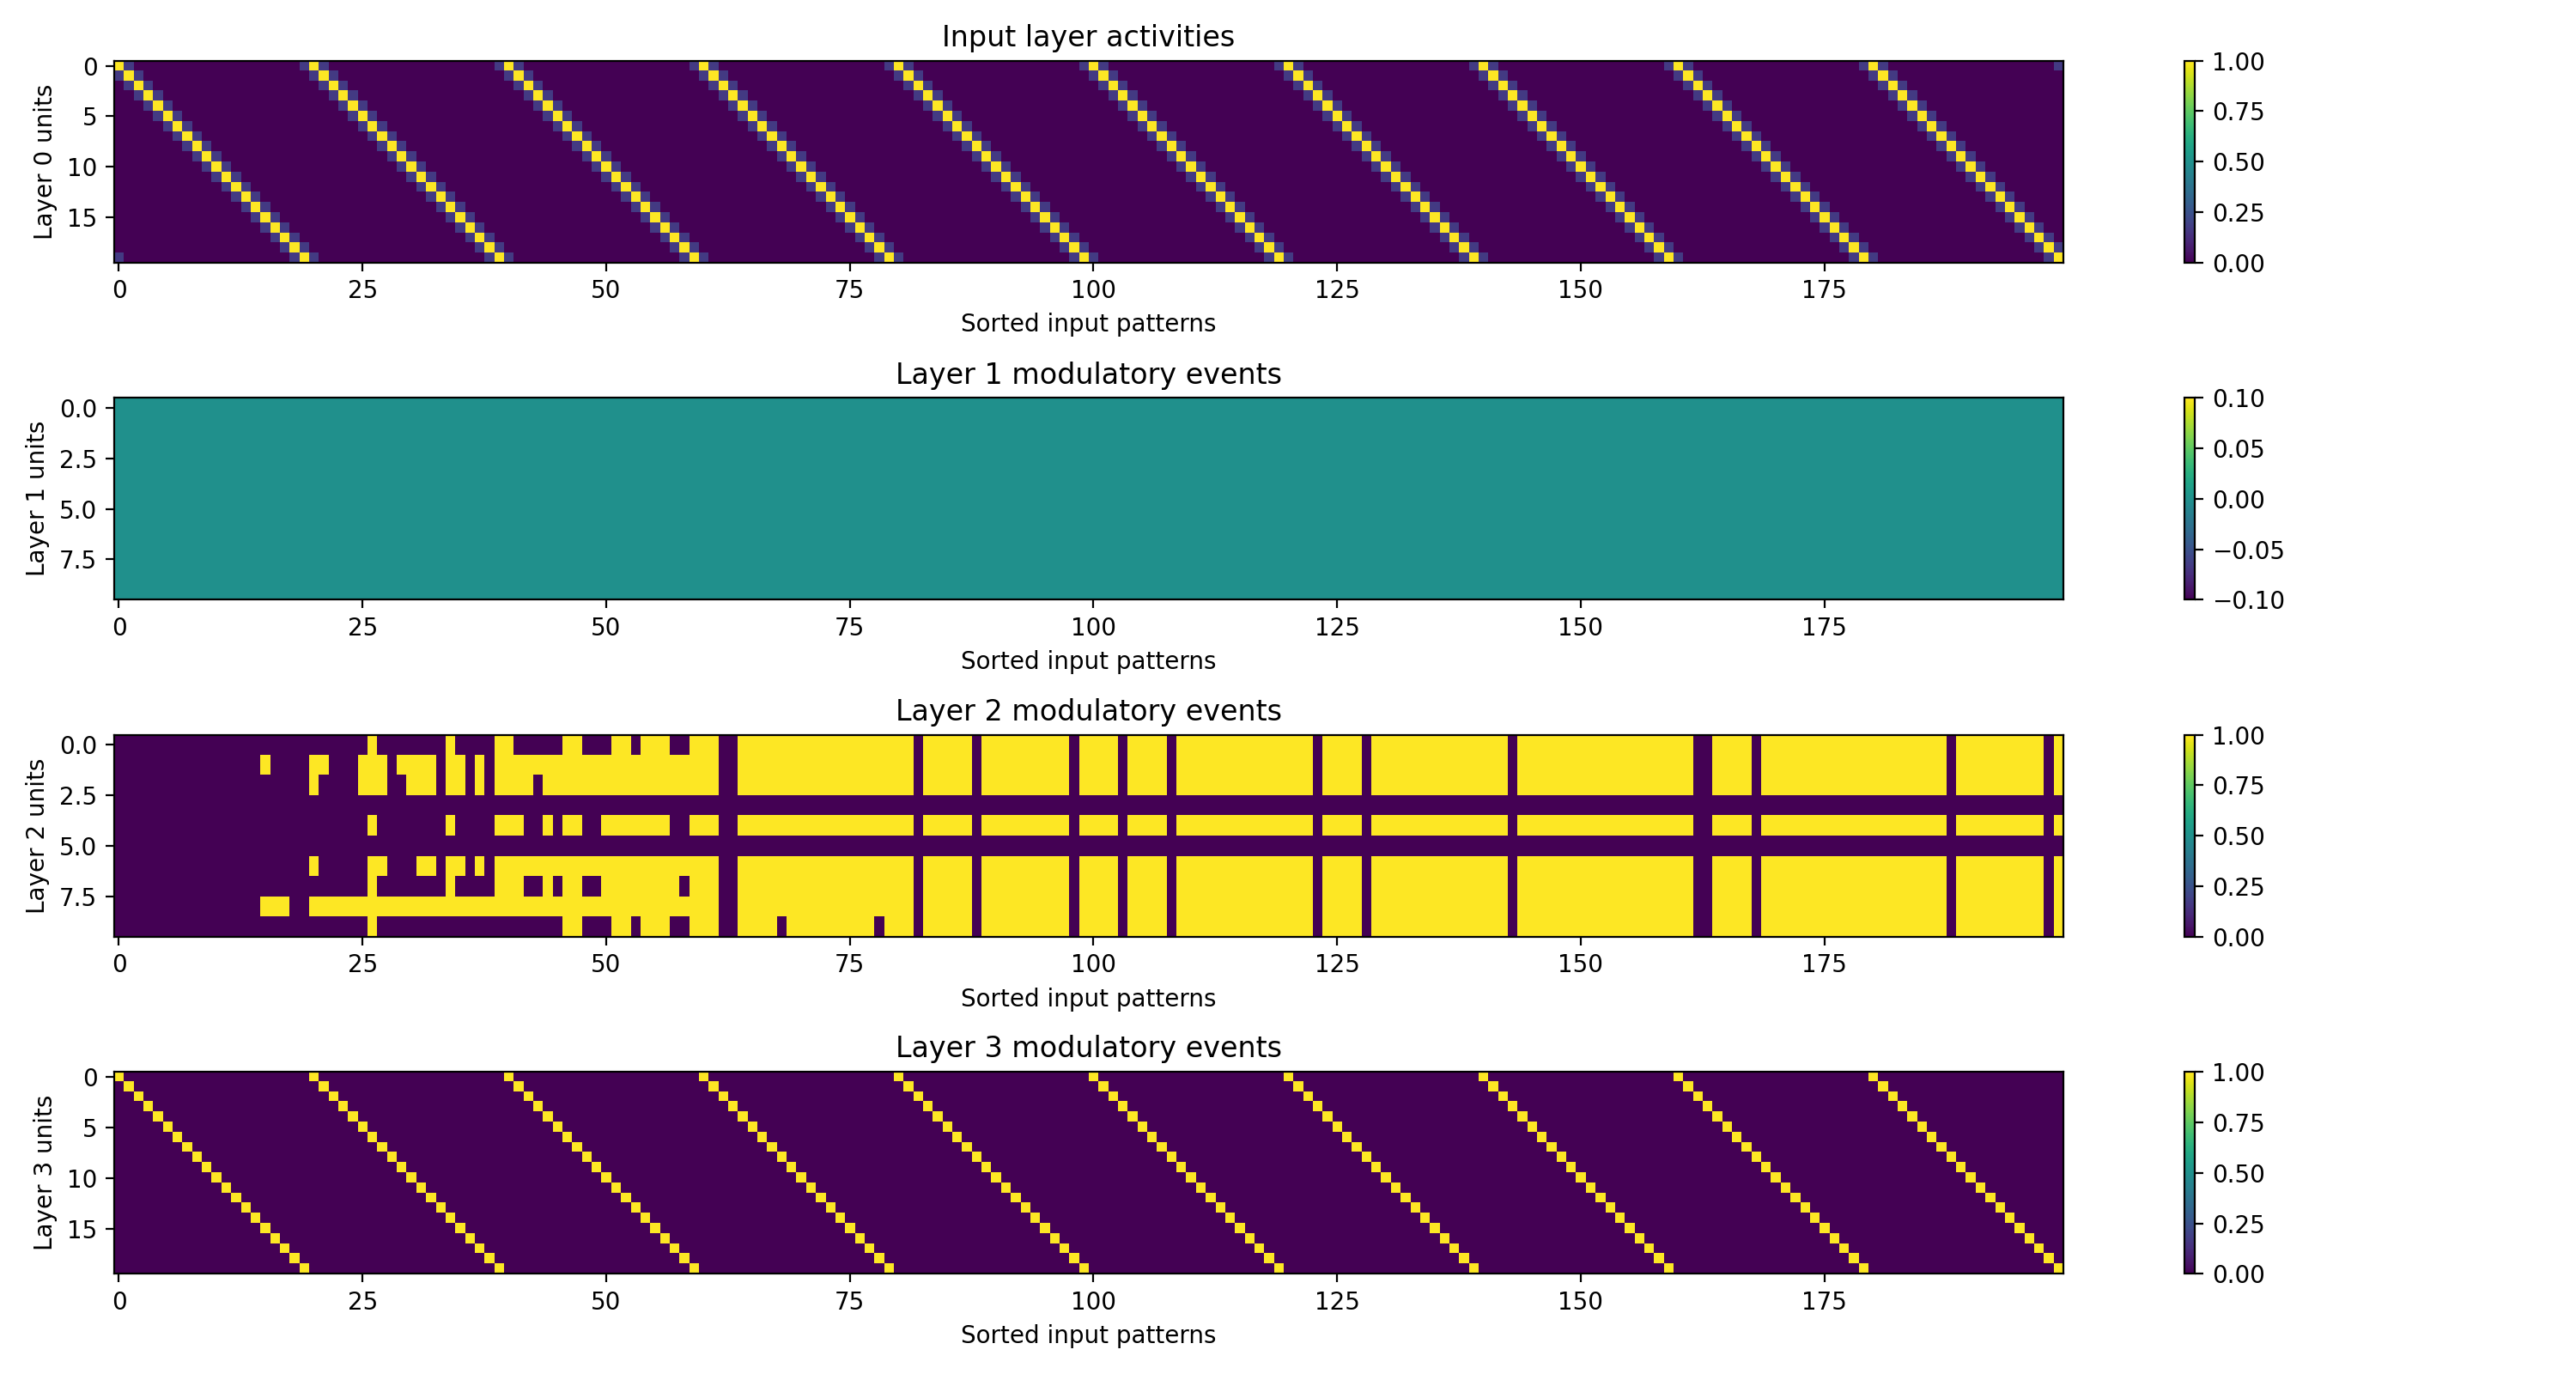

In [12]:
sorted_indexes = []
start_index = 0
for i in range(num_blocks):
    sorted_indexes.extend(np.add(start_index, np.argsort(input_pattern_index_history[start_index:start_index+input_dim])))
    start_index += input_dim
sorted_indexes = np.array(sorted_indexes)

fig, axes = plt.subplots(num_layers, figsize=(num_blocks * 1.5, num_layers * 2.))
cbar = axes[0].imshow(np.column_stack([input_pattern_matrix[:,input_pattern_index_history[i]] for i in sorted_indexes]), aspect='auto')
fig.colorbar(cbar, ax=axes[0])
axes[0].set_ylabel('Layer 0 units')
axes[0].set_xlabel('Sorted input patterns')
axes[0].set_title('Input layer activities')
for layer in range(1, num_layers):
    cbar = axes[layer].imshow(np.column_stack([layer_mod_activities_dict_history[i][layer] for i in sorted_indexes]), aspect='auto')
    fig.colorbar(cbar, ax=axes[layer])
    axes[layer].set_ylabel('Layer %i units' % layer)
    axes[layer].set_xlabel('Sorted input patterns')
    axes[layer].set_title('Layer %i modulatory events' % layer)
fig.tight_layout()
# fig.subplots_adjust(wspace=0.1, hspace=0.2)

<IPython.core.display.Javascript object>


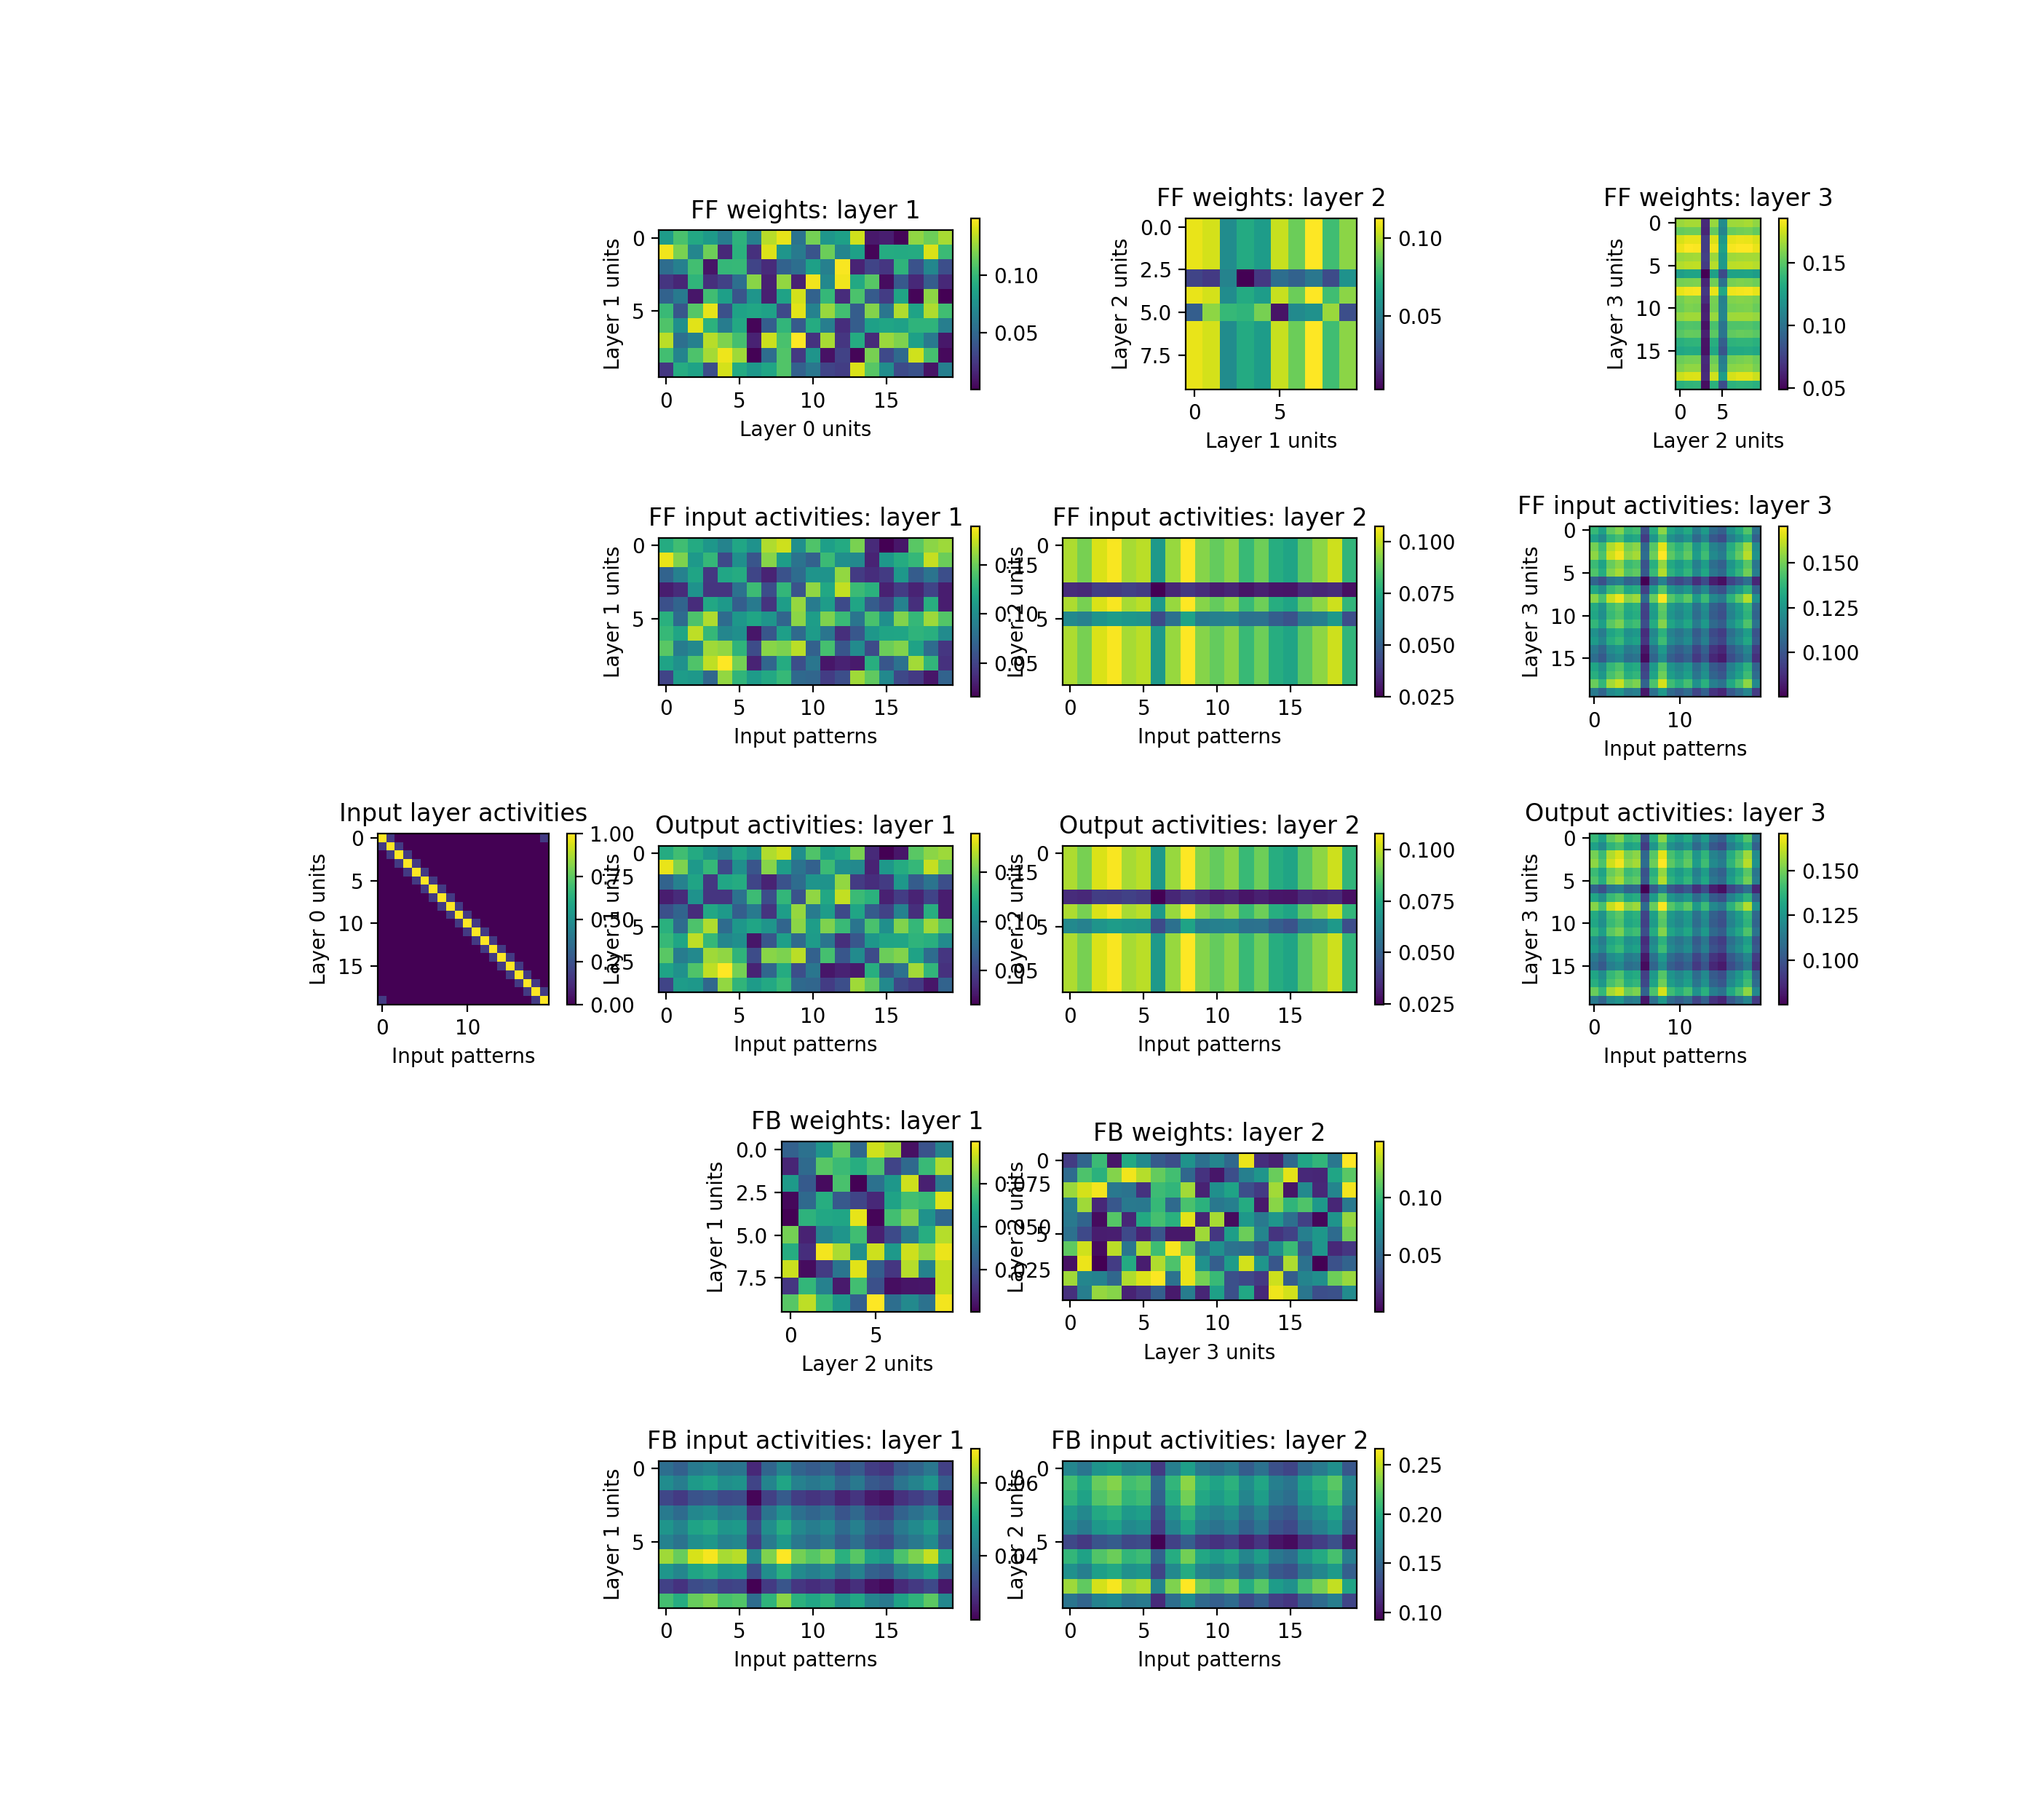

Activity densities:
layer 0: 0.07
layer 1: 0.10
layer 2: 0.08
layer 3: 0.12


In [13]:
FF_input_activities_dict, FB_input_activities_dict, layer_output_activities_dict = \
    get_layer_activities(input_pattern_matrix, FF_weight_matrix_dict_history[-1], FB_weight_matrix_dict_history[-1], activation_f)
plot_network_state_summary(FF_weight_matrix_dict_history[-1], FB_weight_matrix_dict_history[-1], FF_input_activities_dict, FB_input_activities_dict, layer_output_activities_dict)

In [15]:
np.argmax(layer_output_activities_dict[num_layers-1], axis=1)

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])